100%|██████████| 9912422/9912422 [00:01<00:00, 6037294.12it/s]


Extracting ./MNIST/train/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 2070731.02it/s]


Extracting ./MNIST/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2392772.92it/s]


Extracting ./MNIST/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16755082.47it/s]


Extracting ./MNIST/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/train/MNIST/raw



100%|██████████| 9912422/9912422 [00:01<00:00, 5175483.06it/s]


Extracting ./MNIST/test/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/test/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 2032785.05it/s]


Extracting ./MNIST/test/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/test/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2484601.73it/s]


Extracting ./MNIST/test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/test/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12977199.43it/s]


Extracting ./MNIST/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/test/MNIST/raw



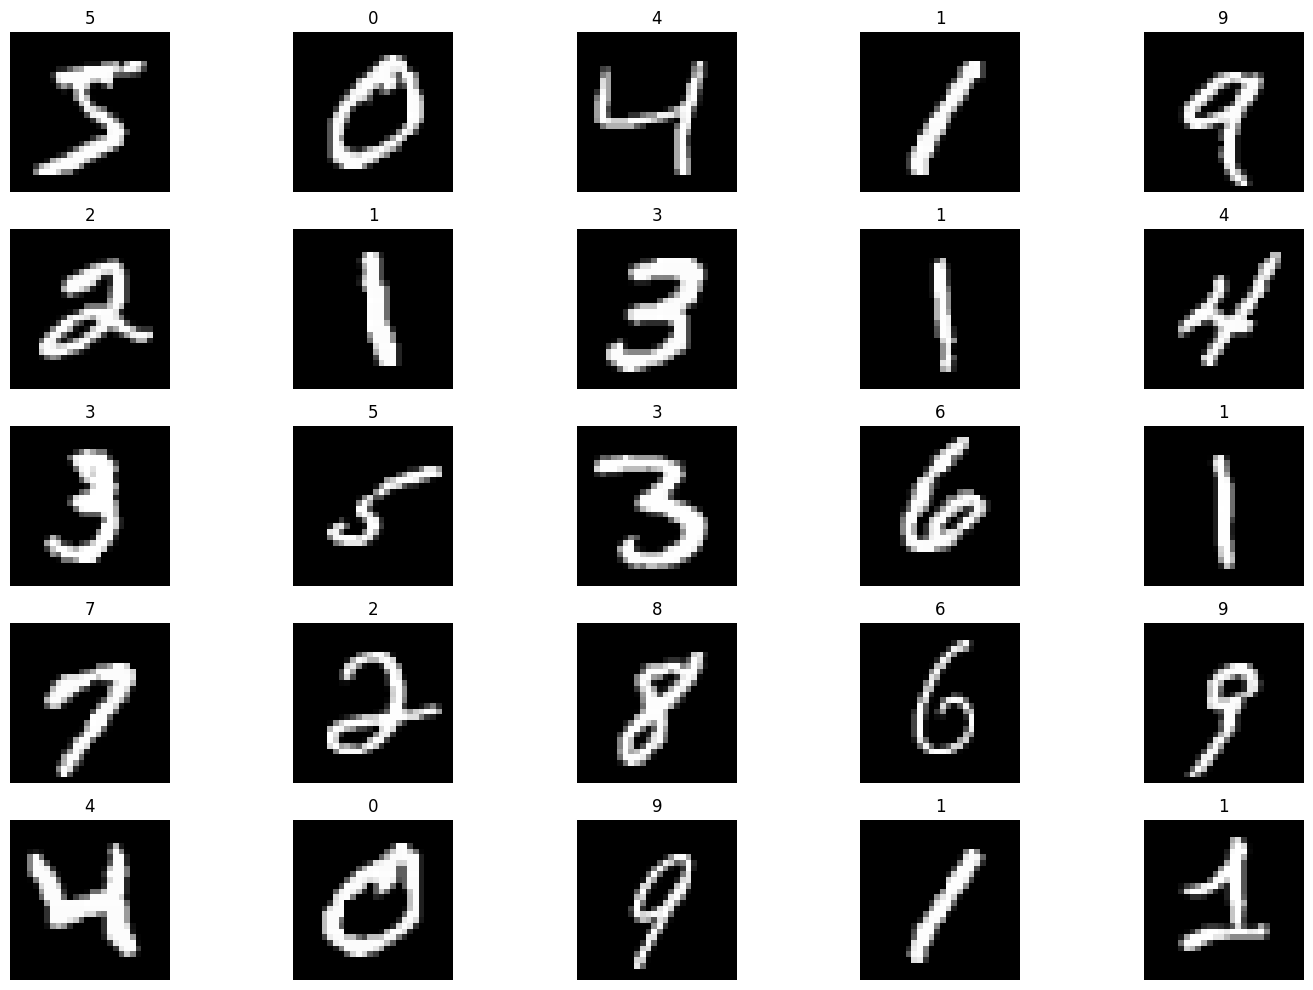

In [1]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
plt.rcParams['figure.figsize'] = 15, 10

# Initializing the transform for the dataset
transform = torchvision.transforms.Compose([
	torchvision.transforms.ToTensor(),
	torchvision.transforms.Normalize((0.5), (0.5))
])

# Downloading the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
	root="./MNIST/train", train=True,
	transform=torchvision.transforms.ToTensor(),
	download=True)

test_dataset = torchvision.datasets.MNIST(
	root="./MNIST/test", train=False,
	transform=torchvision.transforms.ToTensor(),
	download=True)

# Creating Dataloaders from the
# training and testing dataset
train_loader = torch.utils.data.DataLoader(
	train_dataset, batch_size=256)
test_loader = torch.utils.data.DataLoader(
	test_dataset, batch_size=256)

# Printing 25 random images from the training dataset
random_samples = np.random.randint(
	1, len(train_dataset), (25))

for idx in range(random_samples.shape[0]):
	plt.subplot(5, 5, idx + 1)
	plt.imshow(train_dataset[idx][0][0].numpy(), cmap='gray')
	plt.title(train_dataset[idx][1])
	plt.axis('off')

plt.tight_layout()
plt.show()



In [3]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
	def __init__(self):
		super().__init__()		
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(28 * 28, 256),
			torch.nn.ReLU(),
			torch.nn.Linear(256, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 10)
		)
		
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(10, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 256),
			torch.nn.ReLU(),
			torch.nn.Linear(256, 28 * 28),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded

# Instantiating the model and hyperparameters
model = DeepAutoencoder()
m = model.to('cuda')
criterion = torch.nn.MSELoss()
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


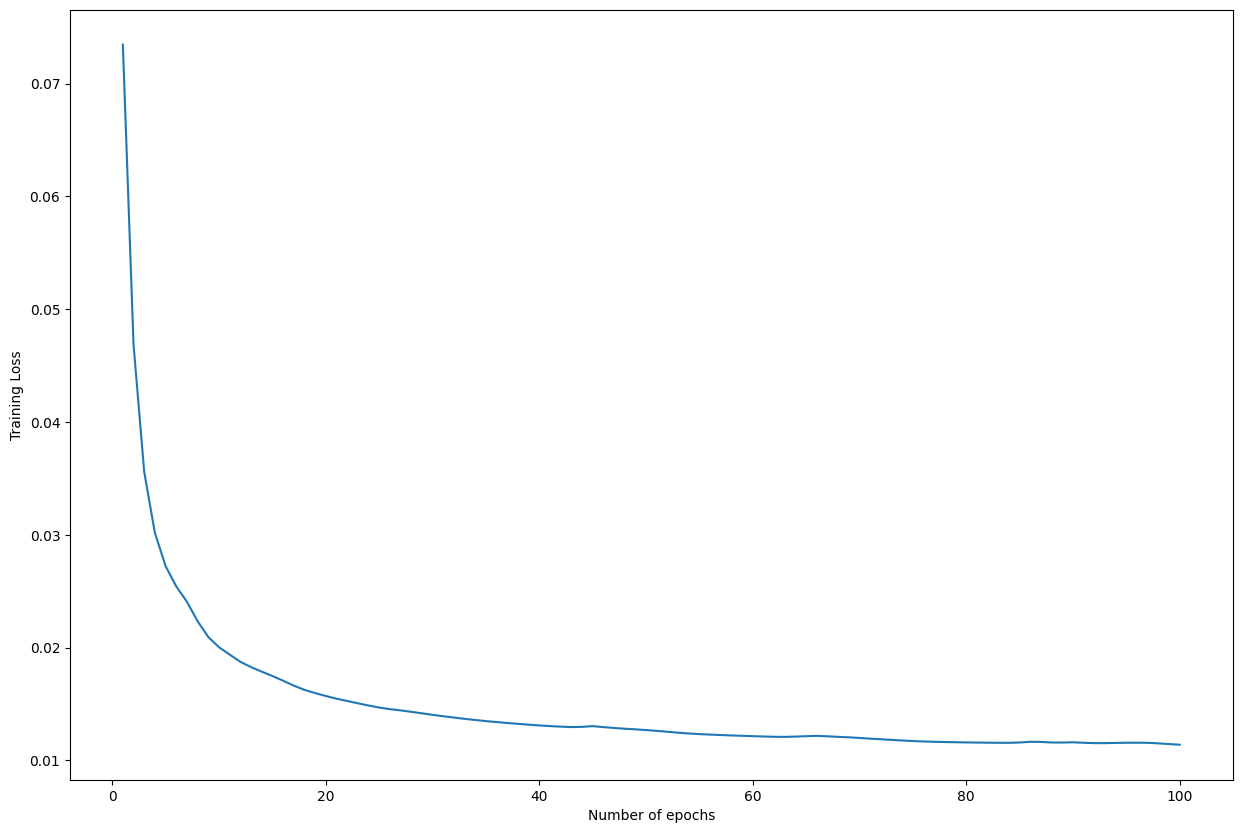

In [5]:
# List that will store the training loss
train_loss = []

# Dictionary that will store the
# different images and outputs for
# various epochs
outputs = {}

batch_size = len(train_loader)

# Training loop starts
for epoch in range(num_epochs):
	print(epoch)
	# Initializing variable for storing
	# loss
	running_loss = 0
	
	# Iterating over the training dataset
	for batch in train_loader:
			
		# Loading image(s) and
		# reshaping it into a 1-d vector
		img, _ = batch
		img = img.to('cuda')
		img = img.reshape(-1, 28*28)
		
		# Generating output
		out = model(img)
		
		# Calculating loss
		loss = criterion(out, img)
		
		# Updating weights according
		# to the calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Incrementing loss
		running_loss += loss.item()
	
	# Averaging out loss over entire batch
	running_loss /= batch_size
	train_loss.append(running_loss)
	
	# Storing useful images and
	# reconstructed outputs for the last batch
	outputs[epoch+1] = {'img': img, 'out': out}





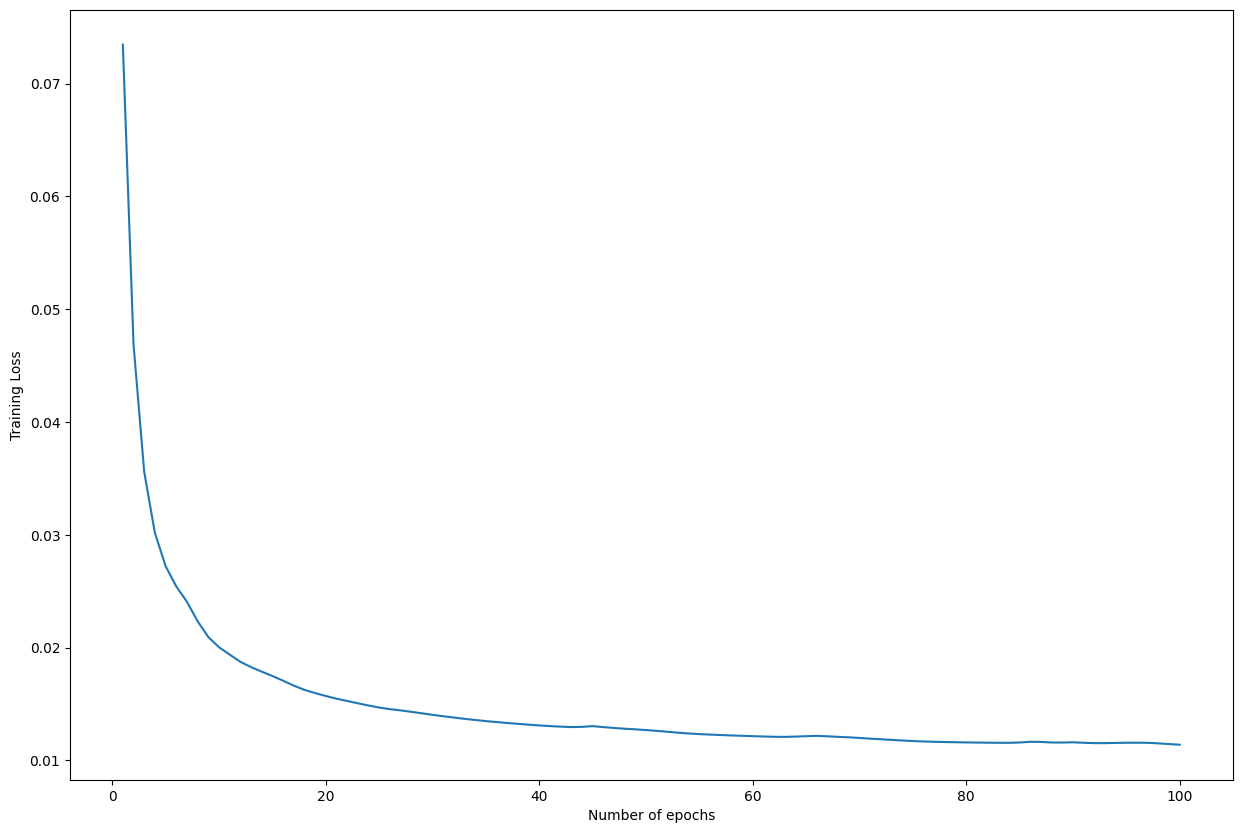

In [6]:
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

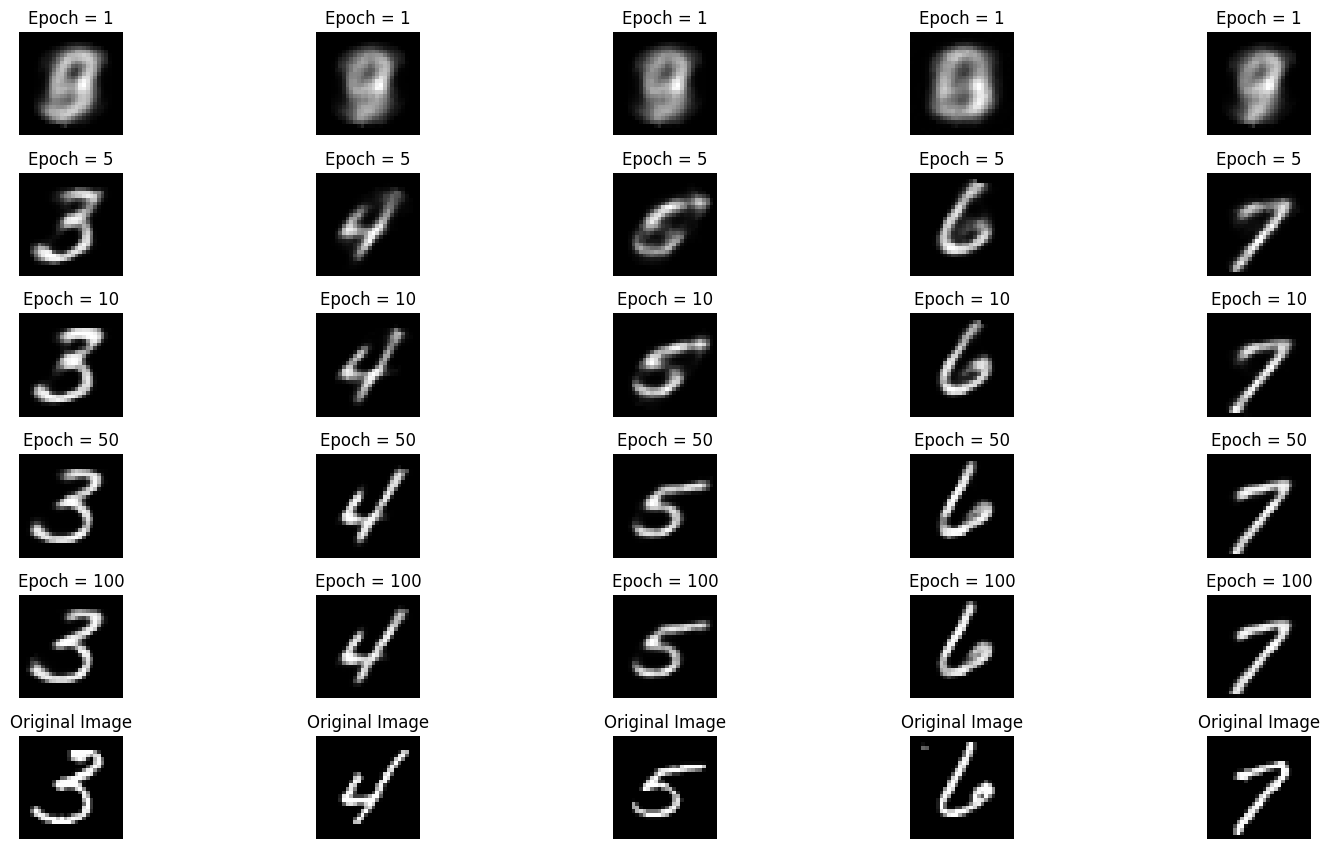

In [9]:
# Plotting is done on a 7x5 subplot
# Plotting the reconstructed images

# Initializing subplot counter
counter = 1

# Plotting reconstructions
# for epochs = [1, 5, 10, 50, 100]
epochs_list = [1, 5, 10, 50, 100]

# Iterating over specified epochs
for val in epochs_list:
	
	# Extracting recorded information
	temp = outputs[val]['out'].detach().cpu().numpy()
	title_text = f"Epoch = {val}"
	
	# Plotting first five images of the last batch
	for idx in range(5):
		plt.subplot(7, 5, counter)
		plt.title(title_text)
		plt.imshow(temp[idx].reshape(28,28), cmap= 'gray')
		plt.axis('off')
		
		# Incrementing the subplot counter
		counter+=1

# Plotting original images

# Iterating over first five
# images of the last batch
for idx in range(5):
	
	# Obtaining image from the dictionary
	val = outputs[10]['img'].cpu()
	
	# Plotting image
	plt.subplot(7,5,counter)
	plt.imshow(val[idx].reshape(28, 28),
			cmap = 'gray')
	plt.title("Original Image")
	plt.axis('off')
	
	# Incrementing subplot counter
	counter+=1

plt.tight_layout()
plt.show()


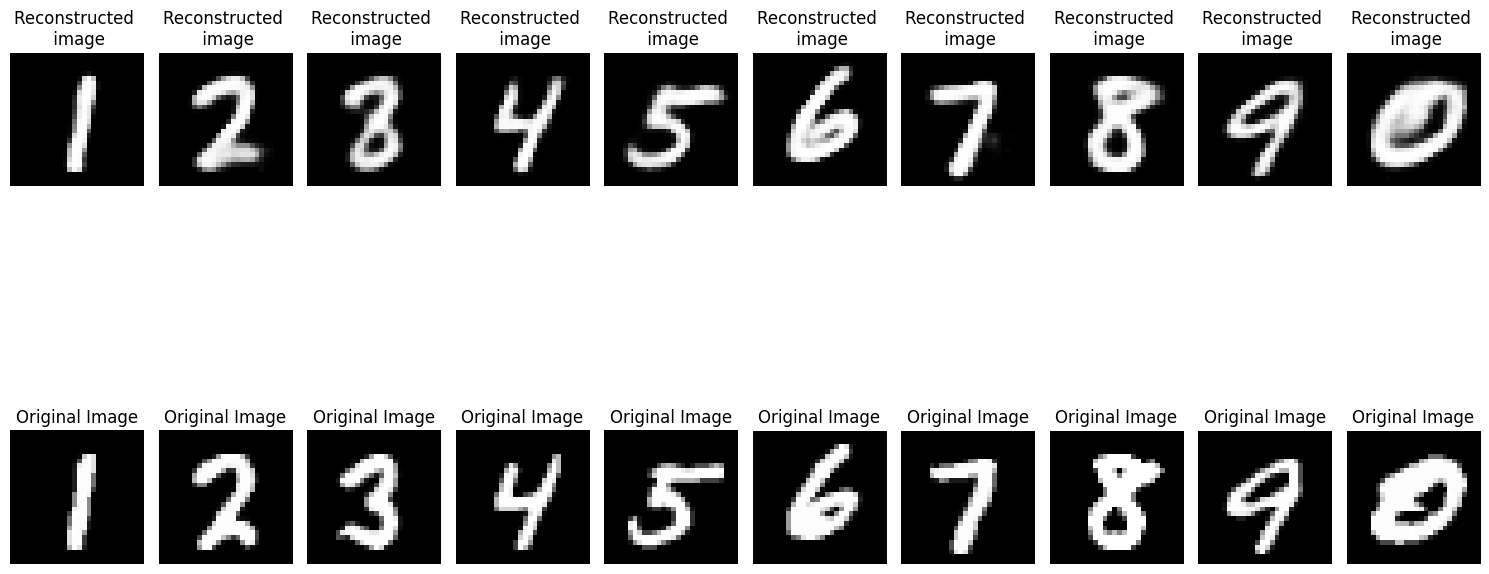

In [27]:
# Dictionary that will store the different
# images and outputs for various epochs
outputs = {}

# Extracting the last batch from the test
# dataset
img, _ = list(test_loader)[-1]

# Reshaping into 1d vector
img = img.reshape(-1, 28 * 28)
img = img.to('cuda')
# Generating output for the obtained
# batch
out = model(img)

# Storing information in dictionary
outputs['img'] = img
outputs['out'] = out

# Plotting reconstructed images
# Initializing subplot counter
counter = 1
val = outputs['out'].detach().cpu().numpy()

# Plotting first 10 images of the batch
for idx in range(10):
	plt.subplot(2, 10, counter)
	plt.title("Reconstructed \n image")
	plt.imshow(val[idx].reshape(28, 28), cmap='gray')
	plt.axis('off')

	# Incrementing subplot counter
	counter += 1

# Plotting original images

# Plotting first 10 images
for idx in range(10):
    val = outputs['img']
    plt.subplot(2, 10, counter)
    plt.imshow(val[idx].cpu().reshape(28, 28), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

	# Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()
